## ECHO Memo 044: Broadband Transmitter Output Evaluation
Mrudula Gopalkrishna <br>
7 Feb 2021

__Summary__ : <span style = "font-size:1em;"> This memo evaluates if the ECHO transmitter designed by <b>Titu Samson</b> compresses any amplifier in the LWA front end electronics or any gain stage in the LWA-SV analog signal path </span> 

__Setup :  (noise diode + BP Filter + Gain + Filter + Gain)  -> Fieldfox__


**Field Fox Spectrum analyzer settings**

* Frequency range: 20- 250MHz
* BW = 230MHz
* Resolution BW: 10KHz
* Tracepoints: 401 points


In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
from scipy.interpolate import interp1d

In [3]:
def dB(x):
    return 10*np.log10(x)

In [4]:
#path to gain files of tx and rx antennas 
file_dir = '/media/sf_Dropbox_ASU/ECHO/LWA_October_2019/data/antenna_gains/' 
#path to transmitter spectrum file
tx_file = '/media/sf_Dropbox_ASU/ECHO/LWA_October_2019/workspace/Mru/new_echo_transmitter_data/A1A2BPFA3A4BPF.csv' 

In [5]:
#function to read fieldfox csv files 
def read_fieldfox(file):
    data = np.array(pd.read_csv(file,skiprows = 32))
    freq = data[:-1,0].astype(float)
    power= data[:-1,1].astype(float)
    return freq, power

In [6]:
# Reading in all the files 
bb_data = np.array(pd.read_csv(file_dir+'blue_bicone_gain.csv'))
bb_freq = bb_data[:,0]
bb_gain = bb_data[:,1]

tx_freq, tx_power = read_fieldfox(tx_file)

lwa_data = np.array(pd.read_csv(file_dir+'lwa_gain.csv'))
lwa_freq = lwa_data[:,0]
lwa_gain = lwa_data[:,1]

freq_list = []
freq_list.append(bb_freq*1e6)
freq_list.append(tx_freq)

<IPython.core.display.Javascript object>


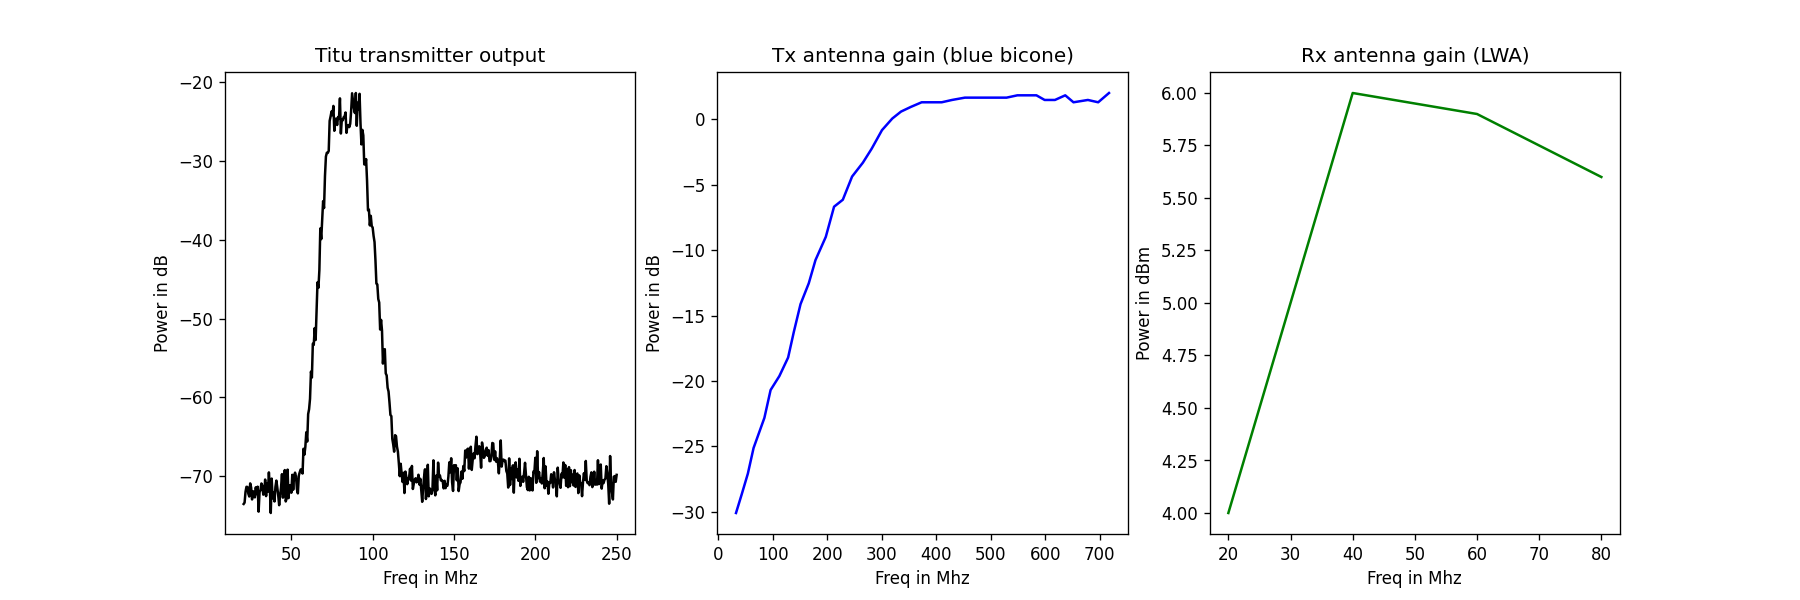

Text(0, 0.5, 'Power in dBm')

In [7]:
#plots of all files 
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.plot(tx_freq/1e6, tx_power, 'k')
plt.title('Titu transmitter output')
plt.xlabel('Freq in Mhz')
plt.ylabel('Power in dB')

plt.subplot(1,3,2)
plt.plot(bb_freq, bb_gain, 'b')
plt.title('Tx antenna gain (blue bicone)')
plt.xlabel('Freq in Mhz')
plt.ylabel('Power in dB')

plt.subplot(1,3,3)
plt.plot(lwa_freq, lwa_gain, 'g')
plt.title('Rx antenna gain (LWA)')
plt.xlabel('Freq in Mhz')
plt.ylabel('Power in dBm')

<span style ="font-size:18px;">  <b> Figure 1 </b> | Figure showing the transmitter spectrum, tx antenna(bicolog5070) gain plot and rx antenna (LWA) gain plot </span>

# Free space path loss calculation 

### Free space path loss = $(\frac{4\pi df}{c})^2 $ <br>
<span style ="font-size:18px;"> where d = distance between rx and tx antennas.<br>
This is derived from the Friis transmission formula and assumes the antennas are isotropic i.e Directivity of the rx and tx antennas are 1.</span>


In [8]:
def propagation_loss_dB(freq, distance):  
    '''
    inputs: freq in Hz
            distance in m
    returns: free space path loss in dB
    '''
    c = 3*1e8 #m/s
    x = (4* np.pi * freq * distance)/c
    return 2*dB(x)

In [9]:
def common_range_arr(freq_list, size):
    min_value = []
    max_value = []
    for i in freq_list:
        min_value.append(min(i))
        max_value.append(max(i))

    lower_limit = max(min_value)
    upper_limit = min(max_value)
    array = np.linspace(lower_limit,upper_limit, size)
    return array

def interp(new_range,orig_range,flux):
    interp_model = interp1d(orig_range,flux, kind = 'cubic')
    interp_value = interp_model(new_range)
    return interp_value

In [10]:
#Finding a common freq list between bicolog data and tx data in Mhz
common_freq = common_range_arr(freq_list, 400)
tx_antenna_gain = interp(common_freq/1e6,bb_freq,bb_gain)
#common_freq

## Link Budget

<span style ="font-size:18px;"> The power at the input to the first LWA gain stage depends on the transmitter power, path loss and the gains of both antennas involved. The LWA antenna has a gain which is close to 6dB is and relatively flat across the spectrum, so here we assume it is constant with frequency. Thus the link budget is: 
<br>
<br>
<b> Received power(dB) = Transmitter power output(dBm) + Gain of Receiving Antenna (dB) + Gain of Transmitting antenna(dB) - Path loss(dB) </b> </span>


In [11]:
rx_antenna_gain= np.full(400,6) #flat 6dBi across all frequencies 
propagation_loss = propagation_loss_dB(common_freq, 100)
link_budget = (tx_power + tx_antenna_gain+rx_antenna_gain) - propagation_loss

<IPython.core.display.Javascript object>


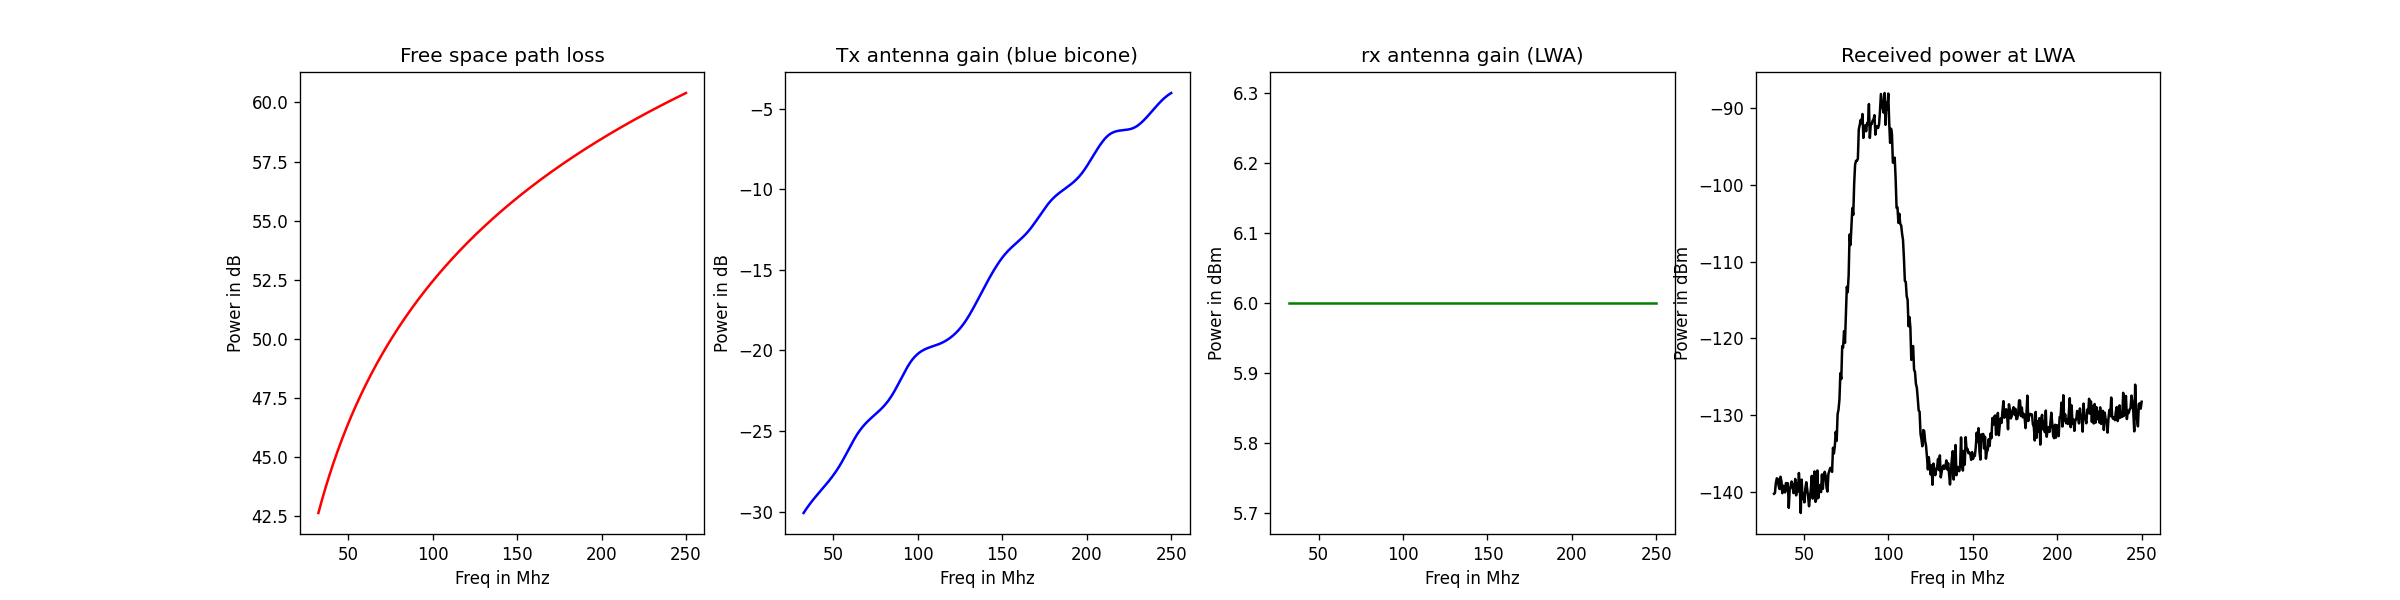

Text(0, 0.5, 'Power in dBm')

In [12]:
plt.figure(figsize=(20, 5))
#figsize=(18, 5)
plt.subplot(1,4,1)
plt.plot(common_freq/1e6, propagation_loss, 'r')
plt.title('Free space path loss')
plt.xlabel('Freq in Mhz')
plt.ylabel('Power in dB')

plt.subplot(1,4,2)
plt.plot(common_freq/1e6, tx_antenna_gain, 'b')
plt.title('Tx antenna gain (blue bicone)')
plt.xlabel('Freq in Mhz')
plt.ylabel('Power in dB')

plt.subplot(1,4,3)
plt.plot(common_freq/1e6, rx_antenna_gain, 'g')
plt.title('rx antenna gain (LWA)')
plt.xlabel('Freq in Mhz')
plt.ylabel('Power in dBm')

plt.subplot(1,4,4)
plt.plot(common_freq/1e6, link_budget, 'k')
plt.title('Received power at LWA')
plt.xlabel('Freq in Mhz')
plt.ylabel('Power in dBm')


<span style ="font-size:18px;"> <b> Figure 2 | </b> Showing elements of the the link budget calculation. Free space path loss according to Friis (note includes $\lambda^2$ effective area), gain of the Bicolog transmitting antenna, flat gain assumed for the receiving antenna, and the resulting received power spectrum as it would be input to the LWA LNA. 
   </span>


## Power Spectral density(PSD)

<br>
 
A spectrum analyzer measures power per filter bandwidth a.k.a resolution bandwidth and the number of datapoints in the output file is set by 'tracepoints'. In this experiment, resolution bandwidth is set to 10KHz and the tracepoints is set to 401 meaning, we have 401 datapoints in terms of dBm/10KHz over our frequency band. However, compression depends on the total power integrated over the band.<br>
<span style ="font-size:18px;">    
Total power within the frequency band or power spectral density can be calculated using the formula - <br>

PSD = $\frac{bandwidth}{resolution\ bandwidth} \frac{1}{tracepoints-1} \sum_{n=1}^{tracepoints}10^{tx power/10} $ dBm/Hz  </span>

In [13]:
res_bw = 1e4 # 10Khz
bw = tx_freq[-1] - tx_freq[0]
trace_points = 401
final_tx_output = np.sum(10**(link_budget/10))* (bw/res_bw) * (1/(trace_points-1))
print('Total tx output = ',dB(final_tx_output), 'dBm')

Total tx output =  -57.64112239633064 dBm


# Check for Compression at the LWA analog signal chain

The LWA signal chain has a number of amplifiers with varying compression points which are described by Dowell et al in [memo lwa0214][1] <br>
Assuming a flat LWA gain of 6dBi, input power at LWA front end = -58dBm. Here we reproduce the system diagram indicating the total expected power at each point. 

[1]: http://www.phys.unm.edu/~lwa/memos/memo/lwa0214.pdf

__Green highlight indicates power below compression point, red for over limit.__


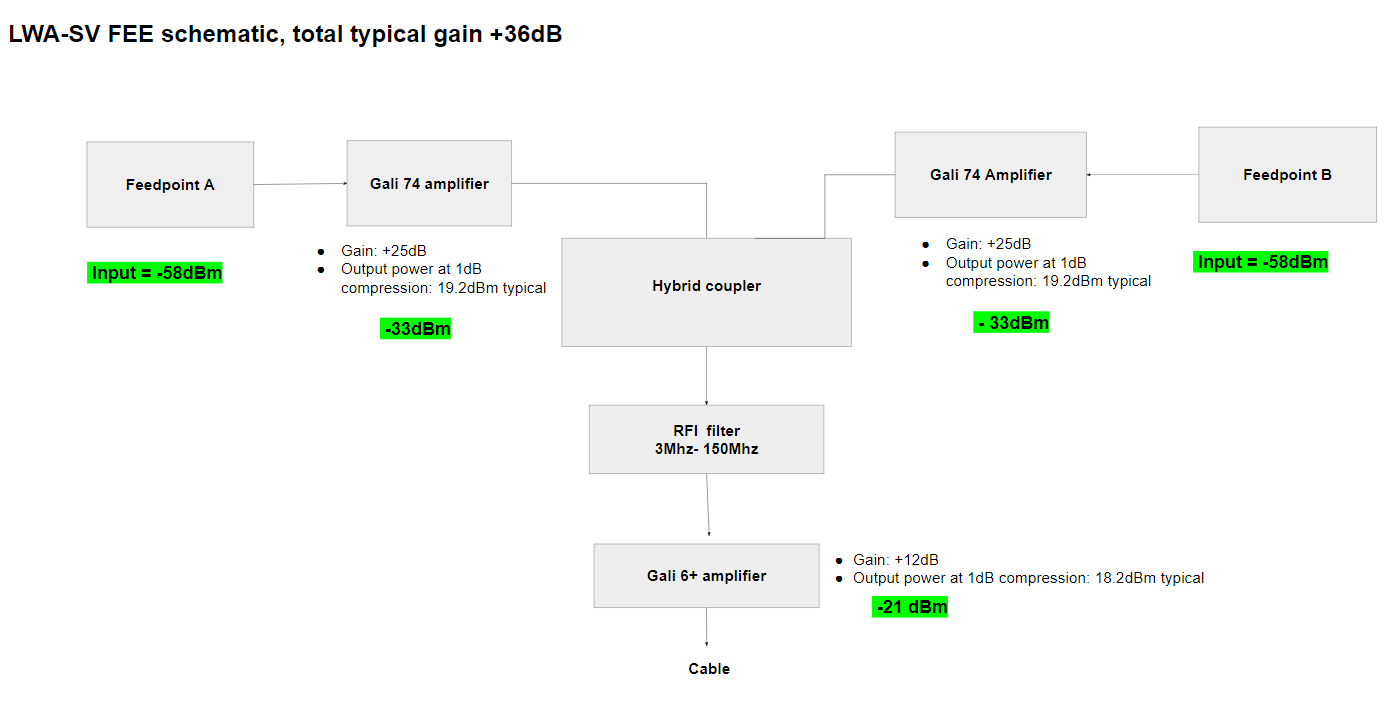

In [14]:
Image(filename='LWA_FEE.PNG', width=1000)

<span style ="font-size:18px;">  <b> Figure 3 </b> | RF signal chain of LWA-Sevilleta- This is the portion inside the antenna stand
   </span>

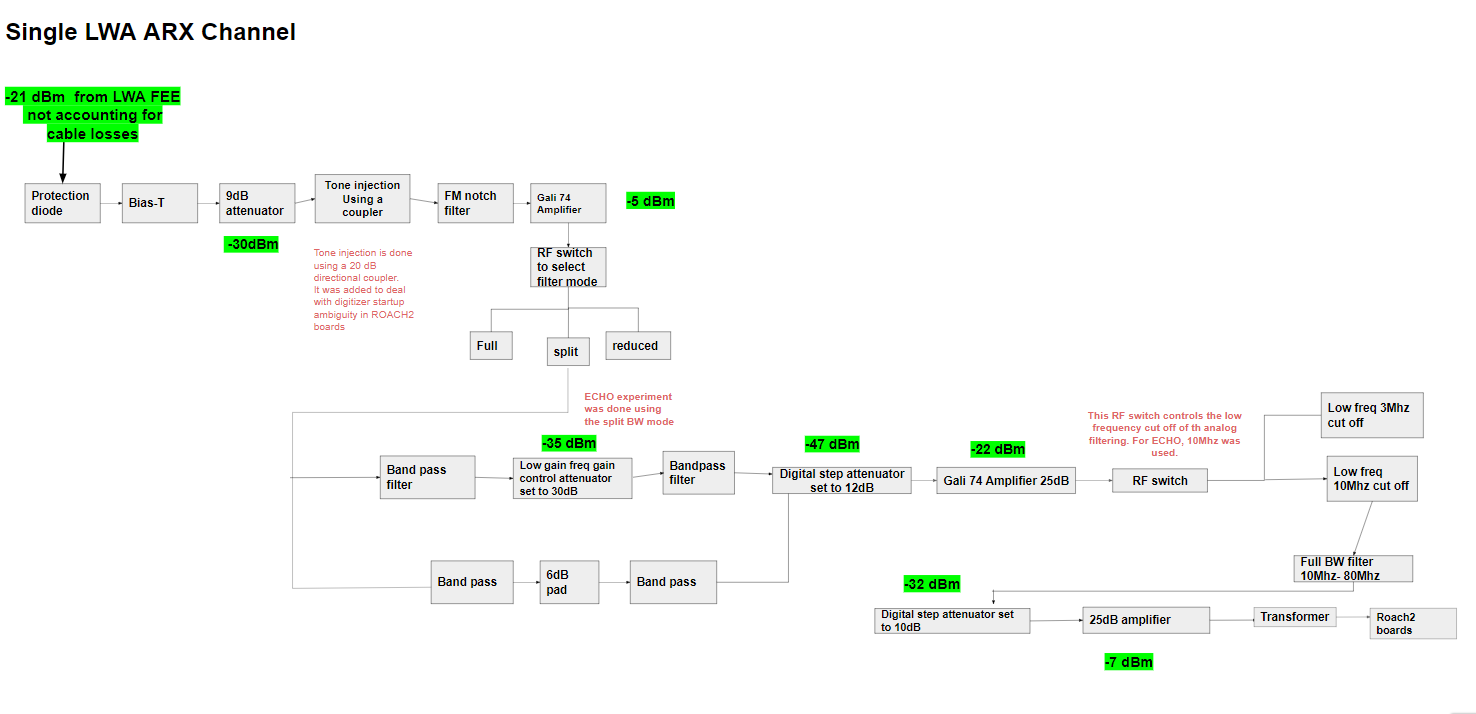

In [15]:
Image(filename= 'LWA_analog_path.PNG')

<span style ="font-size:18px;">  <b> Figure 4 </b> | RF signal chain of LWA-Sevilleta- This is the portion inside the Analog Receiver(ARX) Board
   </span>

## Conclusion

The memo evaluates if the broadband transmitter designed for ECHO causes any part of the LWA analog signal chain to operate in the non-linear regime. From the link budget calculation, the total power at the LWA front end would be -58dBm. From our calculations, we see that the output at every gain stage is well within the specified 1dB compression point. Hence, we conclude that the given transmitter does not cause the electronics in the LWA signal chain to operate inthe non-linear regime. 